# 2) Distribuzioni di Gumbel

La distribuzione dei massimi di precipitazioni dei dati analizzati appartiene alla famiglia di distribuzioni di Gumbel. L’affermazione precedente è lecita in quanto, secondo il teorema di Gumbel, i valori massimi dei dati relativi ad un insieme di campioni di opportuna numerosità appartiene alle seguenti famiglie di distribuzione:
- Distribuzione di Gumbel (curva dei valori estremi di tipo 1);
- Distribuzione di Fréchet (curva dei valori estremi di tipo 2);
- Distribuzione di Weibull (curva dei valori estremi di tipo 3).
La distribuzione di Gumbel è espressa dalla seguente formula: 

$$ P[H<h; a,b] = e^{-e-{\frac{h-a}{b}}}$$

Queste distribuzioni al loro interno contengono 2 parametri:
- a = parametro di posizione (legato alla deviazione standard);
- b = fattore di forma (legato alla moda).


## Operazioni preliminari

In [2]:
import os
from pandas import *
import pandas as pd
import numpy as np
from numpy import linspace
import datetime as datetime
import matplotlib.pyplot as plt
import math
from scipy.stats import genextreme, gumbel_r
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
os.getcwd()
os.listdir()

['.ipynb_checkpoints',
 '1)Introduzione.ipynb',
 '2)Gumbel.ipynb',
 '3)TestDiPearson.ipynb',
 '4)CurvePossPluv.ipynb',
 'df_aEb_m',
 'df_aEb_mq',
 'df_aEb_mv',
 'df_best_aEb',
 'fotoStazione.png',
 'Gumbel_pearson.png',
 'LetturaFileExcel.ipynb',
 'LSPP_massima_verosimiglianza.png',
 'LSPP_minimi_quadrati.png',
 'LSPP_momenti.png',
 'MassimiDiPrecipCavalese.xls']

In [4]:
data = pd.ExcelFile('MassimiDiPrecipCavalese.xls')
data
data.sheet_names
df = data.parse('DATI', header = 2)
df.columns
df.rename(columns = {'anno':'Anno'}, inplace = True)
df.set_index("Anno", inplace = True)
df.head()

,1 ora,3 ore,6 ore,12 ore,24 ore
Anno,,,,,
1962,24.0,41.6,42.8,42.8,60.5
1963,10.4,15.0,18.8,32.0,35.8
1964,28.6,34.8,38.4,40.0,56.4
1965,18.8,30.2,31.0,35.2,39.2
1966,21.0,22.0,33.0,59.6,102.2


## 2.1) Metodo dei momenti

Il metodo dei momenti è uno dei metodi utilizzati per la determinazione dei parametri a e b della distribuzione di Gumbel. Tale metodo ha validità generale e consiste nell'uguagliare due momenti, il momento di un campione di dati e il momento della popolazione.
Il metodo dei momenti richiede la risoluzione di:
\begin{equation}
\left\{
\begin{array}{l}
b \gamma + a = \mu_H \\
b^2  \frac{\pi^2}{6} = \sigma^2_H
\end{array}
\right.
\end{equation}
con a e b parametri della curva di Gumbel:
$$b = \frac{\sqrt{6}}{\pi} \sigma_H \qquad a = \mu_H -\frac{\sqrt{6}\gamma}{\pi} \sigma_H$$

Per comodità nei conti si introducono altre due costanti:
$$C = \frac{\sqrt{6}}{\pi} \qquad d = \frac{\sqrt{6}\gamma}{\pi}$$

Ottenedo cosi che:

$$b=C\,\sigma_H\qquad e \qquad a=\mu_H - d\sigma_H$$


### Calcolo delle costanti C e d

In [5]:
#Calcolo di C
C = math.sqrt(6) / math.pi
C

0.779696801233676

In [6]:
#Calcolo di d
costEulMasc = 0.577215664901532860606512090
d = costEulMasc*C
d

0.4500532075456946

### Determinazione dei parametri a e b al variare delle durate

Costruire una funzione che ha come input i dataframe delle medie e delle deviazioni standard e che restituisce un dataframe costituito da 2 vettori in cui:
- primo vettore -> rappresenta i valori di a al variare delle durate (1 ora, 3 ore, 6 ore, 12 ore, 24 ore);
- secondo vettore -> rappresenta i valori di b al variare delle stesse durate di a.

Il metodo dei momenti permette quindi di ottenere le coppie di a e b per tutte le durate, contemporaneamente.

In [7]:
media = df.mean()
devStandard = df.std()
def g(m, s):
    return pd.DataFrame([m - 0.4500532075456946 * s, 0.779696801233676 * s], index = ["a","b"])
df_aEb_m = g(media, devStandard)
df_aEb_m

,1 ora,3 ore,6 ore,12 ore,24 ore
a,17.116492,24.077547,30.859582,39.772437,50.772806
b,5.777373,6.671090,6.853249,10.024914,16.407705


### Costruzione delle curve di Gumbel 

Salvare il dataframe dei parametri a e b in un formato leggibile dal sistema.

In [8]:
df_aEb_m.to_pickle("df_aEb_m")

Definire una funzione che ritorna l'espressione della curva di Gumbel.

In [9]:
def gumbel(x, df_g, time):
    return np.exp( - np.exp( - (x-df_g[time]["a"]) / df_g[time]["b"])) 

Determinare i valori minimi e massimi di precipitazione per tutte le fasce orarie.

In [10]:
vMin = df.min()[0]
vMin

10.2

In [11]:
vMax = df.max()[4]
vMax

116.8

Creare un'ascissa che va dal valore minimo al valore massimo di precipitazione indicando il numero d'intervalli in cui la si vuole dividere.

In [12]:
x_gumbel = np.linspace(vMin, vMax, 100)

Definire un dataframe contenente le espressione delle distribuzioni di Gumbel interpolate, nelle diverse fasce orarie.

In [13]:
df_gb_m = pd.DataFrame([gumbel(x_gumbel, df_aEb_m, "1 ora"),
                 gumbel(x_gumbel, df_aEb_m, "3 ore"),
                 gumbel(x_gumbel, df_aEb_m, "6 ore"),
                 gumbel(x_gumbel, df_aEb_m, "12 ore"),
                 gumbel(x_gumbel, df_aEb_m, "24 ore")]).T
df_gb_m.index = x_gumbel
df_gb_m.columns = ["1 ora","3 ore","6 ore","12 ore","24 ore"]
df_gb_m.head()

,1 ora,3 ore,6 ore,12 ore,24 ore
10.200000,0.036489,0.000333,1.409154e-09,5.049707e-09,0.000007
11.276768,0.064070,0.001099,2.728163e-08,3.533632e-08,0.000015
12.353535,0.102228,0.003035,3.432965e-07,2.028265e-07,0.000031
13.430303,0.150655,0.007202,2.989245e-06,9.744057e-07,0.000059
14.507071,0.207854,0.015025,1.900187e-05,3.989679e-06,0.000110


Costruire un grafico in cui si sovrappongono dati e curve interpolate. Nella costruzione del grafico è importante rimuovere i termini in cui vi è l'assenza dei dati di misura (NaN), tramite il comando .dropna().

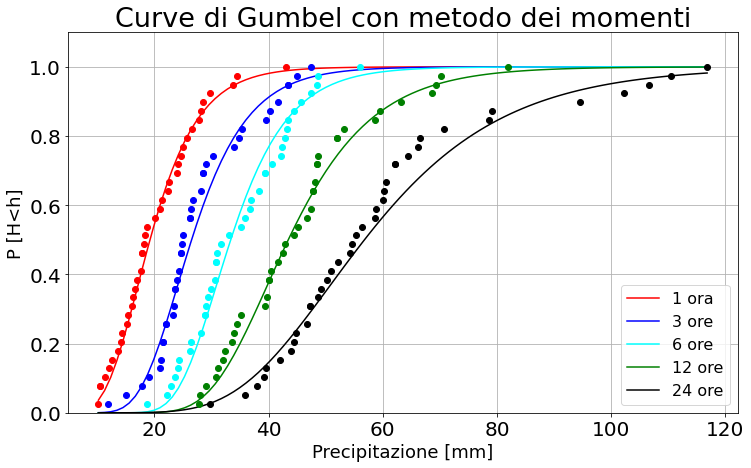

In [14]:
# Curve di Gumbel relative alle varie fasce orarie
plt.rc('xtick', labelsize = 20) 
plt.rc('ytick', labelsize = 20) 
ax_m = df_gb_m.plot(color=["red", "blue", "cyan", "green", "black"], figsize = (12,7))
ax_m.set_title('Curve di Gumbel con metodo dei momenti', fontsize = 27)
ax_m.set_xlabel('Precipitazione [mm]', fontsize = 18)
ax_m.set_ylabel('P [H<h]', fontsize = 18)
plt.legend(prop = {"size":16}, loc = 4)
ax_m.grid()
# Rimozione dei NaN
df_1h = df["1 ora"].dropna()
df_3h = df["3 ore"].dropna()
df_6h = df["6 ore"].dropna()
df_12h = df["12 ore"].dropna()
df_24h = df["24 ore"].dropna()
# ECDF relative alle varie fasce orarie
ecdf_1h = ECDF(df_1h)
ecdf_3h = ECDF(df_3h)
ecdf_6h = ECDF(df_6h)
ecdf_12h = ECDF(df_12h)
ecdf_24h = ECDF(df_24h)
# Rappresentazione dell'andamento effettivo dei dati determinati sperimentalmente
ax_m.plot(df_1h, ecdf_1h(df_1h), "o", c = "red", label = "1 ora")
ax_m.plot(df_3h, ecdf_3h(df_3h), "o", c = "blue", label = "3 ore")
ax_m.plot(df_6h, ecdf_6h(df_6h), "o", c = "cyan", label = "6 ore")
ax_m.plot(df_12h, ecdf_12h(df_12h), "o", c = "green", label = "12 ore")
ax_m.plot(df_24h, ecdf_24h(df_24h), "o", c = "black", label = "24 ore")
ax_m.set_ybound(lower = 0, upper = 1.1)
plt.savefig("Gumbel_momenti.png", dpi = 600)

### Valutazione dei risultati

Da tale grafico si può evincere che i dati rilevati dalla stazione considerata interpolano con buona approssimazione le curve teoriche di Gumbel relative alle diverse fasce orarie considerate.
Si può osservare inoltre che la miglior interpolazione si ha con la curva relativa alla durata di 1 ora, mentre la peggior interpolazione si ha con quella relativa alla durata di 24 ore.

## 2.2) Metodo della massima verosimiglianza

Il metodo della massima verosimiglianza è uno dei metodi utilizzati per la determinazione della coppia dei parametri a e b più probabili della distribuzione di Gumbel.
In tale metodo la coppia di parametri a e b è associata al punto di massimo assoluto della funzione di verosimiglianza. Questa funzione permette di calcolare la probabilità di ottenere tutta la serie temporale (composta da n elementi) ed è espressa dalla seguente formula:
\begin{equation}
{\rm argmax}_{a,b} P[\{h_1, \cdot \cdot, h_n \};a,b] = {\rm argmax}_{a,b} \prod_i^n P[h_i;a,b]
\end{equation}

### Ricerca dei parametri a e b della curva di Gumbel

I parametri vengono stimati sulla base della probabilità che i coefficienti della popolazione siano uguali a quelli del campione.
Per semplificare il calcolo viene effettuato un ciclo for sugli intervalli utilizzando la funzione gumbel_r.fit che restituisce i parametri a e b più probabili.

In [15]:
ore=["1 ora", "3 ore", "6 ore", "12 ore", "24 ore"]
def samp(data, colData):
    
    sample = data[colData].dropna()
    param = gumbel_r.fit(sample)
    return param

samplex=[]
for i in range(len(ore)):
    samplex.append(samp(df, ore[i]))

Creare un dataframe contenente i parametri a e b.

In [16]:
df_aEb_mv = pd.DataFrame(samplex, columns = ["a","b"], index = ore).T 
df_aEb_mv

,1 ora,3 ore,6 ore,12 ore,24 ore
a,17.096393,24.025645,30.614184,39.748338,51.263666
b,5.723790,6.911913,7.541314,9.885428,14.547560


### Costruzione delle curve di Gumbel

Salvare il dataframe dei parametri a e b in un formato leggibile dal sistema.

In [17]:
df_aEb_mv.to_pickle("df_aEb_mv")

Definire una funzione che ritorna l'espressione della curva di Gumbel e successivamente creare un'ascissa che va dal valore minimo al valore massimo di precipitazione indicando il numero d'intervalli in cui la si vuole dividere.
Infine definire un dataframe contenente le espressione delle distribuzioni di Gumbel interpolate, nelle diverse fasce orarie (stesso procedimento attuato nel metodo dei momenti).

In [18]:
def gumbel(x, df_g, time):
    return np.exp(- np.exp( - (x - df_g[time]["a"]) / df_g[time]["b"])) 
x_gumbel = np.linspace(vMin, vMax, 100)
df_gb_mv = pd.DataFrame([gumbel(x_gumbel, df_aEb_mv, ore[0]),
                         gumbel(x_gumbel, df_aEb_mv, ore[1]),
                         gumbel(x_gumbel, df_aEb_mv, ore[2]),
                         gumbel(x_gumbel, df_aEb_mv, ore[3]),
                         gumbel(x_gumbel, df_aEb_mv, ore[4])]).T
df_gb_mv.index = x_gumbel
df_gb_mv.columns = ore
df_gb_mv.head()

,1 ora,3 ore,6 ore,12 ore,24 ore
10.200000,0.035568,0.000617,3.108518e-07,2.353407e-09,4.943930e-08
11.276768,0.063028,0.001791,2.282534e-06,1.828757e-08,1.641752e-07
12.353535,0.101250,0.004461,1.285498e-05,1.150052e-07,5.004442e-07
13.430303,0.149953,0.009739,5.752355e-05,5.982272e-07,1.408866e-06
14.507071,0.207620,0.018997,2.108772e-04,2.624863e-06,3.683950e-06


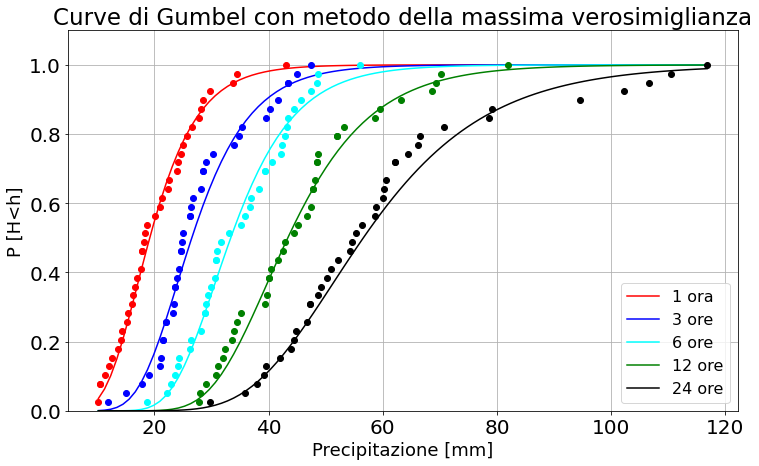

In [20]:
#Curve di Gumbel relative alle varie fasce orarie
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
colori = ["red", "blue", "cyan", "green", "black"]
ax_mv = df_gb_mv.plot(color = colori, figsize = (12, 7))
ax_mv.set_title('Curve di Gumbel con metodo della massima verosimiglianza', fontsize = 23)
ax_mv.set_xlabel('Precipitazione [mm]', fontsize = 18)
ax_mv.set_ylabel('P [H<h]', fontsize = 18)
plt.legend(prop = {"size":16}, loc = 4)
ax_mv.grid()
# Rappresentazione dell'andamento effettivo dei dati determinati sperimentalmente
def componenti(data, colore, ora):  
    data = data[ora].dropna()
    ecdf = ECDF(data)
    dot = ax_mv.plot(data, ecdf(data), 'o', c = colore)
    return dot

for i in range(len(colori)):
    comp = componenti(df, colori[i], ore[i]) 
ax_mv.set_ybound(lower = 0, upper = 1.1)
plt.savefig("Gumbel_massima_verosimiglianza.png", dpi = 600)

### Valutazione dei risultati

Valgono le osservazioni fatte per il metodo dei momenti

## 2.3) Metodo dei minimi quadrati

Tale metodo iterativo consiste nel definire lo scarto quadratico tra le misure dell'ECDF (Empirycal Cumulative Distribution Function) e la probabilità di non superamento del singolo candidato h(i).
In tale metodo si prendono i valori di a e b che rendono lo scarto quadratico minimo.
\begin{equation} 
\delta^2(a,b) = \sum_i^N (ECDF_i-P[h_i;a,b])^2 \to \rm min 
\end{equation}

### Ricerca dei parametri a e b della curva di Gumbel

Essendo il metodo dei minimi quadrati un processo iterativo è necessario fornire una condzione iniziale (x0 [a,b]) dal quale partire con l'iterazione. In questo caso si prende come condizione iniziale i valori di a e b ottenuti con il metodo dei momenti.

In [21]:
x0 = samplex
x0

[(17.096392527995473, 5.723789778640177),
 (24.025644909402875, 6.911913480364508),
 (30.614183888167258, 7.541314270491289),
 (39.74833754029827, 9.885427853843334),
 (51.26366584502196, 14.547559817520744)]

Si definiscono delle funzioni necessarie per la stima ai minimi quadrati

In [23]:
# Valori dei dati ordinati in ordine crescente (ascissa)
def t_rain(data, h):  
    return sorted(data[h].dropna())

# Valori della funzione empirica cumulata ordinati (ordinata)
def y_t_rain(data, h):  
    ecdf = ECDF(data[h])
    t_rain = sorted(data[h].dropna())
    return ecdf(t_rain)

# Distribuzione di Gumbel 
def fun(x, t, y): 
    return np.exp( - np.exp( - (t - x[0]) / x[1])) - y

Si applica il metodo dei minimi quadrati tramite la funzione least_squares (metodo iterativo per risolvere il sistema non lineare ottenuto tramite il metodo dei minimi quadrati).

In [24]:
from scipy.optimize import least_squares
aEb_mq = []
for i in range(len(ore)):
    ris_mq = least_squares(fun, x0[i], args=(t_rain(df, ore[i]), y_t_rain(df, ore[i]))) 
    aEb_mq.append(ris_mq.x)
    #le x della funzione contengono i valore di a e di b

Si crea il dataframe relativo ai parametri a e b determinati tramite il metodo dei minimi quadrati

In [25]:
df_aEb_mq = pd.DataFrame(aEb_mq, columns = ["a", "b"], index = ore).T 
df_aEb_mq

,1 ora,3 ore,6 ore,12 ore,24 ore
a,17.071434,23.964007,30.801410,39.728183,50.640086
b,6.763814,6.604094,8.995085,11.323566,14.421141


### Costruzione delle curve di Gumbel

In [26]:
df_aEb_mq.to_pickle("df_aEb_mq")

Definire una funzione che ritorna l'espressione della curva di Gumbel e successivamente creare un'ascissa che va dal valore minimo al valore massimo di precipitazione indicando il numero d'intervalli in cui la si vuole dividere.
Infine definire un dataframe contenente le espressione delle distribuzioni di Gumbel interpolate, nelle diverse fasce orarie (stesso procedimento attuato negli altri 2 metodi).

In [27]:
def gumbel(x, df_g, time):
    return np.exp(- np.exp( - (x - df_g[time]["a"]) / df_g[time]["b"])) 
x_gumbel = np.linspace(vMin, vMax, 100)
df_gb_mq = pd.DataFrame([gumbel(x_gumbel, df_aEb_mq, ore[0]),
                         gumbel(x_gumbel, df_aEb_mq, ore[1]),
                         gumbel(x_gumbel, df_aEb_mq, ore[2]),
                         gumbel(x_gumbel, df_aEb_mq, ore[3]),
                         gumbel(x_gumbel, df_aEb_mq, ore[4])]).T
df_gb_mq.index = x_gumbel
df_gb_mq.columns = ore
df_gb_mq.head()

,1 ora,3 ore,6 ore,12 ore,24 ore
10.200000,0.063173,0.000323,0.000051,0.000001,6.729166e-08
11.276768,0.094854,0.001082,0.000156,0.000004,2.207824e-07
12.353535,0.134154,0.003024,0.000420,0.000013,6.650327e-07
13.430303,0.180300,0.007238,0.001010,0.000037,1.850410e-06
14.507071,0.232001,0.015192,0.002200,0.000094,4.783195e-06


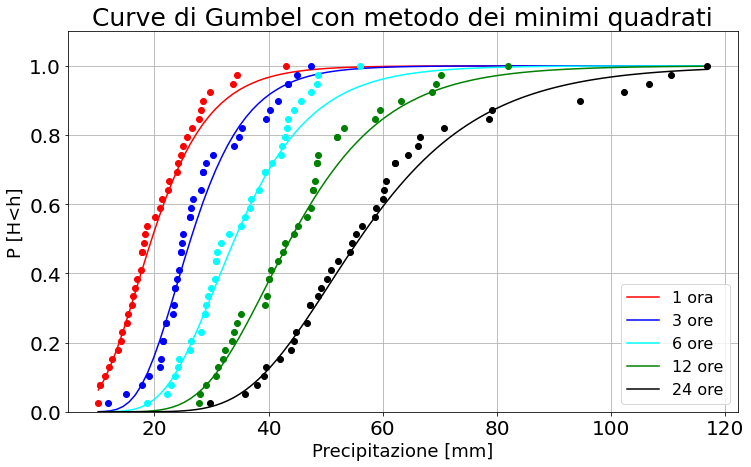

In [28]:
#Curve di Gumbel relative alle varie fasce orarie
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
colori = ["red", "blue", "cyan", "green", "black"]
ax_mq = df_gb_mq.plot(color=colori, figsize = (12, 7))
ax_mq.set_title('Curve di Gumbel con metodo dei minimi quadrati', fontsize = 25)
ax_mq.set_xlabel('Precipitazione [mm]', fontsize = 18)
ax_mq.set_ylabel('P [H<h]', fontsize = 18)
plt.legend(prop = {"size":16}, loc = 4)
ax_mq.grid()
# Rappresentazione dell'andamento effettivo dei dati determinati sperimentalmente
def componenti(data, colore, ora):  
    data = data[ora].dropna()
    ecdf = ECDF(data)
    dot = ax_mq.plot(data, ecdf(data), 'o', c = colore)
    return dot

for i in range(len(colori)):
    comp = componenti(df, colori[i], ore[i]) 
ax_mq.set_ybound(lower = 0, upper = 1.1)
plt.savefig("Gumbel_minimi_quadrati.png", dpi = 600)

### Valutazione dei risultati

Valgono le osservazioni fatte per gli altri 2 metodi. L'unica differenza che si nota è una maggiore divergenza dei dati sperimentali rispetto alle curve di Gumbel per la durata di 6 ore.